In [42]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import cv2


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5,enable_segmentation=True)


In [43]:
image_path = r"F:\AI\BodyFatModel\test_cases\files\2\front_img.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

if image.shape[1] > 1500:
    target_width = 230
else:
    target_width = 330
aspect_ratio = image.shape[1] / image.shape[0]
target_height = int(target_width / aspect_ratio)
resized_image = cv2.resize(image_rgb, (target_width, target_height))



In [44]:
results = pose.process(resized_image)
landmarks = results.pose_landmarks


distance between ankle and head 392.47335662792807


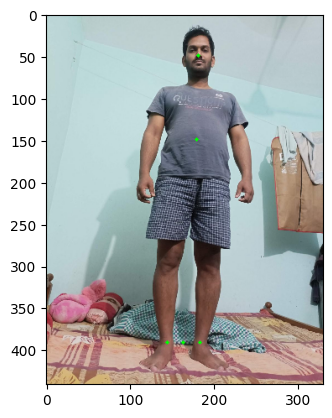

In [45]:
image_width = resized_image.shape[1]
image_height = resized_image.shape[0]
                              
if landmarks:
    nose_x = int(landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width)
    nose_y = int(landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height)
    ankle_x = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].x * image_width)
    ankle_y = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE].y * image_height)
    ankle_x2 = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].x * image_width)
    ankle_y2 = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE].y * image_height)
    left_shoulder_x = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * image_width)
    left_shoulder_y = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * image_height)
    right_shoulder_x = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * image_width)
    right_shoulder_y = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * image_height)
    left_hip_x = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].x * image_width)
    left_hip_y = int(landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP].y * image_height)
    right_hip_x = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].x * image_width)
    right_hip_y = int(landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP].y * image_height)

    upper_body_center_x=(left_shoulder_x+right_shoulder_x+left_hip_x+right_hip_x)//4
    upper_body_center_y=(left_shoulder_y+right_shoulder_y+left_hip_y+right_hip_y)//4
    waist_center = (upper_body_center_x, upper_body_center_y)
    





    ankle_center_x = (ankle_x + ankle_x2) // 2
    ankle_center_y = (ankle_y + ankle_y2) // 2
    nose_ankle_distance = np.sqrt((nose_x - ankle_center_x) ** 2 + (nose_y - ankle_center_y) ** 2)+50
    print("distance between ankle and head" , nose_ankle_distance)

    cv2.circle(resized_image, (upper_body_center_x, upper_body_center_y), 2, (0, 255, 0), -1)
    cv2.circle(resized_image, (ankle_center_x, ankle_center_y), 2, (0, 255, 0), -1)
    cv2.circle(resized_image, (ankle_x2, ankle_y2), 2, (0, 255, 0), -1)
    cv2.circle(resized_image, (ankle_x, ankle_y), 2, (0, 255, 0), -1)
    cv2.circle(resized_image, (nose_x, nose_y), 2, (0, 255, 0), -1)
    plt.imshow(resized_image)

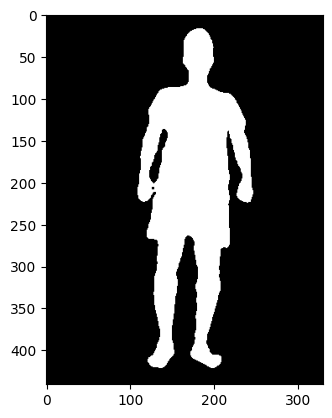

In [46]:
mask_resized = cv2.resize(results.segmentation_mask, (resized_image.shape[1], resized_image.shape[0]))

smoothed_image = cv2.GaussianBlur(mask_resized, (5, 5), 0)
BG_COLOR=(0,0,0)
# Convert the mask to a binary mask
binary_mask = smoothed_image > 0.8

# Apply mask on image with gray background
bg_image = np.zeros(resized_image.shape, dtype=np.uint8)
bg_image[:] = BG_COLOR  # Black background
image_with_mask_overlay = resized_image.copy()
image_with_mask_overlay[binary_mask] = (255, 255, 255)  # Green overlay color

# # Apply mask on image with gray background
# bg_image = np.zeros(resized_image.shape, dtype=np.uint8)
# bg_image[:] = BG_COLOR
image_with_mask = np.where(binary_mask[:, :, np.newaxis], image_with_mask_overlay, bg_image)
plt.imshow(image_with_mask)

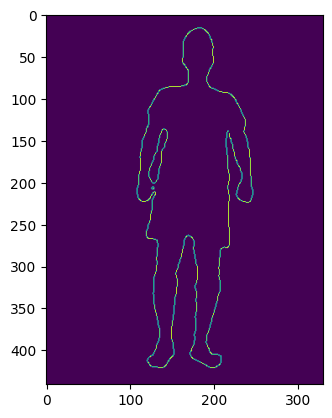

In [47]:
gray_image = cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray_image, 1, 100)  # Adjust the thresholds as needed

# Find contours in the edge-detected image
contours, hierarchy = cv2.findContours(edges,
    cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Create an empty black background
bg_image = np.zeros_like(edges)

# Draw the contours on the black background
contour_color = 192  # gray color
cv2.drawContours(bg_image, contours, -1, contour_color, 1)



# Display the image with the detected outer body edge
plt.imshow( bg_image)

closest_right_point (214, 149)
closest_left_point (144, 148)
70.00714249274856


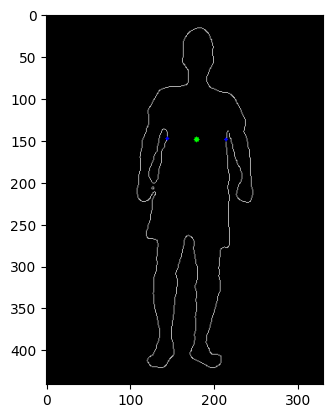

In [48]:
closest_right_point = None
closest_left_point = None
min_distance_right = float('inf')
min_distance_left = float('inf')

for contour in contours:
    for contour_point in contour:
        contour_point = tuple(contour_point[0])
        distance = np.linalg.norm(np.array(waist_center) - np.array(contour_point))

        # Check if the point is to the right or left of the given point
        if contour_point[0] > waist_center[0] and distance < min_distance_right:
            min_distance_right = distance
            closest_right_point = contour_point
        elif contour_point[0] < waist_center[0] and distance < min_distance_left:
            min_distance_left = distance
            closest_left_point = contour_point

# Draw circles at the closest points
image_with_circles = cv2.cvtColor(bg_image, cv2.COLOR_GRAY2BGR)
cv2.circle(image_with_circles, waist_center, 3, (0, 255, 0), -1)  # Draw a green circle at the upper body center
cv2.circle(image_with_circles, closest_right_point, 2, (0, 0, 255), -1)
cv2.circle(image_with_circles, closest_left_point, 2, (0, 0, 255), -1)
plt.imshow( image_with_circles)



distance_between_points = np.linalg.norm(np.array(closest_right_point) - np.array(closest_left_point))

print("closest_right_point",closest_right_point)
print ("closest_left_point",closest_left_point)
print(distance_between_points)


In [49]:
waist = distance_between_points
height = nose_ankle_distance
waist_to_height_ratio = waist / height
print("waist_to_height_ratio",waist_to_height_ratio)
print("waist",waist)
print("height",height)

waist_to_height_ratio 0.1783742547372881
waist 70.00714249274856
height 392.47335662792807


In [55]:
actual = 165 / 95
print("actual percent",actual)

actual percent 1.736842105263158


In [56]:
circumstences = waist*3.1415927
print(circumstences)

219.93392780307866


In [57]:
predicted_percent = height/(circumstences)
print("predicted percent",predicted_percent)

predicted percent 1.7845057401936428


In [58]:
actually = 64 - (20*(actual))
predictedly = 64 - (20*(predicted_percent))

print("actual body fat percent",actually)
print("predicted body fat percent",predictedly)

actual body fat percent 29.263157894736842
predicted body fat percent 28.30988519612714
